In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#use ggplot style
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('eataly_data.csv')

In [4]:
df.shape

(828151, 16)

In [5]:
df.head()

,Unnamed: 0,TicketDate,TicketTime,PriorVisits,SaleLines,ReturnLines,NetAmount,NetRetailAmount,NetQSRAmount,StationGroup,UniqueItems,UniqueCategories,HasRetailProducts,HasQSRProducts,ReturnedBags,WillReturn
0,0,2015-08-31,14:07:30,0,4,0,13.20,13.20,0,Other,2,1,True,False,False,True
1,1,2015-08-31,14:15:12,30,2,0,6.60,6.60,0,Other,2,1,True,False,False,True
2,2,2015-08-31,14:17:04,1,3,0,6.16,6.16,0,Other,2,2,True,False,False,False
3,3,2015-08-31,14:25:18,0,1,0,2.80,2.80,0,Other,1,1,True,False,False,True
4,4,2015-08-31,14:25:49,0,1,0,3.40,3.40,0,Other,1,1,True,False,False,True


In [6]:
# convert "StationGroup" to binary "IsFrontEnd"
df['IsFrontEnd'] = df['StationGroup'] == 'Front End'

In [7]:
df.dtypes

Unnamed: 0             int64
TicketDate            object
TicketTime            object
PriorVisits            int64
SaleLines            float64
ReturnLines          float64
NetAmount            float64
NetRetailAmount      float64
NetQSRAmount         float64
StationGroup          object
UniqueItems          float64
UniqueCategories     float64
HasRetailProducts     object
HasQSRProducts        object
ReturnedBags          object
WillReturn              bool
IsFrontEnd              bool
dtype: object

In [8]:
# drop date/time variables b/c i'm not sure how they perform in k-means
dfkm = df.drop(['TicketDate','TicketTime'], axis=1).copy()

In [9]:
# drop StationGroup categorical variable for k-means
dfkm.drop(['StationGroup'], axis=1, inplace=True)

In [10]:
dfkm.head()

,Unnamed: 0,PriorVisits,SaleLines,ReturnLines,NetAmount,NetRetailAmount,NetQSRAmount,UniqueItems,UniqueCategories,HasRetailProducts,HasQSRProducts,ReturnedBags,WillReturn,IsFrontEnd
0,0,0,4,0,13.20,13.20,0,2,1,True,False,False,True,False
1,1,30,2,0,6.60,6.60,0,2,1,True,False,False,True,False
2,2,1,3,0,6.16,6.16,0,2,2,True,False,False,False,False
3,3,0,1,0,2.80,2.80,0,1,1,True,False,False,True,False
4,4,0,1,0,3.40,3.40,0,1,1,True,False,False,True,False


In [11]:
#handle query error of null values, should not be in the data set
dfkm.fillna(0, inplace=True)

In [12]:
# separate the data set into features and prediction
X = dfkm.drop('WillReturn',axis=1).copy()
y = dfkm['WillReturn']

In [13]:
# scale / center data for k-means
scale = StandardScaler()
X_scale = pd.DataFrame(scale.fit_transform(X))
X_scale.columns = X.columns

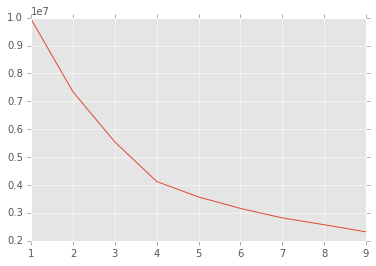

In [113]:
# finding the elbow plotting inertia
k = []
i = []
for n in range(1,10):
    km2 = KMeans(n_clusters=n, n_jobs=-1, random_state=7)
    km2.fit(X_scale)
    k.append(n)
    i.append(km2.inertia_)
    
plt.plot(k, i);

In [114]:
list(zip(k,i))

[(1, 9937812.0000000019),
 (2, 7336238.014930903),
 (3, 5542899.654321136),
 (4, 4124587.7518848842),
 (5, 3569935.6593475738),
 (6, 3160342.3856491344),
 (7, 2820046.9171273848),
 (8, 2575937.5081859659),
 (9, 2320671.6267331806)]

In [89]:
# plotting silhouette score
k = []
s = []
for n in range(2,5):
    km2 = KMeans(n_clusters=n, n_jobs=-1, random_state=7)
    km2.fit(X_scale)
    centers = km2.fit_predict(X_scale)

    k.append(n)
    s.append(silhouette_score(X_scale, centers))

plt.plot(k,s);

MemoryError: 

In [14]:
# create kmeans with 4 clusters, get cluster labels
km = KMeans(n_clusters=4, n_init=20, random_state=7)
km.fit(X_scale)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=7, tol=0.0001,
    verbose=0)

In [15]:
centers = km.cluster_centers_

In [16]:
# show cluster centers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
dfclus = pd.DataFrame(columns, index=X.columns).copy()
dfclus.columns=['Lunch Junkie','Sampler','Regular','Pro']
dfclus

,Lunch Junkie,Sampler,Regular,Pro
Unnamed: 0,425078.542,396950.507,415036.071,410265.426
PriorVisits,2.169,3.715,6.016,3.169
SaleLines,1.686,12.731,5.437,3.112
ReturnLines,0.001,0.001,1.034,0.003
NetAmount,14.348,105.513,39.195,22.872
NetRetailAmount,1.702,102.935,38.506,22.479
NetQSRAmount,12.604,2.138,0.722,0.324
UniqueItems,1.638,11.536,6.075,2.896
UniqueCategories,1.262,5.850,3.991,2.041
HasRetailProducts,0.186,1.000,0.994,0.993


In [105]:
# show cluster centers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
dfclus = pd.DataFrame(columns, index=X.columns).copy()
dfclus.columns=['Lunch Junkie','Sampler','Regular','Pro']
dfclus

,Lunch Junkie,Sampler,Semi-pro,Pro
PriorVisits,2.170,3.711,3.169,6.016
SaleLines,1.687,12.728,3.111,5.437
ReturnLines,0.001,0.001,0.003,1.034
NetAmount,14.349,105.468,22.869,39.195
NetRetailAmount,1.706,102.893,22.474,38.506
NetQSRAmount,12.604,2.137,0.323,0.722
UniqueItems,1.638,11.534,2.895,6.075
UniqueCategories,1.263,5.849,2.041,3.991
HasRetailProducts,0.186,1.000,0.993,0.994
HasQSRProducts,0.998,0.161,0.032,0.062


In [107]:
# get labels
labels = km.labels_

In [111]:
# get specific inertia / silhouette score
print('inertia:\t {:.2f}'.format(km.inertia_))
#print('silhouette:\t {:.5f}'.format(silhouette_score(X_scale, labels)))

inertia:	 4124586.03
